In [132]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import brainbox.io.one as bbone

from math import *
import sys
import scipy.stats as scist
from os import path
import matplotlib.pyplot as plt


###############################
import numpy as np
from one.api import ONE

one = ONE()

from ibllib.atlas import AllenAtlas

# atlas of 10um resolution #
# ba = AllenAtlas(10)
ba = AllenAtlas(10)
# compute ba.top 
#ba.compute_surface()
def compute_top(ba):
    axz = ba.xyz2dims[2]  # this is the dv axis
    _surface = (ba.label == 0).astype(np.int8) * 2
    l0 = np.diff(_surface, axis=axz, append=2)
    _top = np.argmax(l0 == -2, axis=axz).astype(float)
    _top[_top == 0] = np.nan
    ba.top = ba.bc.i2z(_top + 1)

    return ba

ba = compute_top(ba)


################# input: list_region_id, list_region_value ###############################
#################  list_region_id: numpy array of Beryl region id ########################
#################  list_region_value: numpy array of values, ordered by list_region_id ###




######## create slieces %%%%%%%%%%%
def _take(vol, ind, axis, mode):
            if mode == 'clip':
                ind = np.minimum(np.maximum(ind, 0), vol.shape[axis] - 1)
            if axis == 0:
                return vol[ind, :, :]
            elif axis == 1:
                return vol[:, ind, :]
            elif axis == 2:
                return vol[:, :, ind]

def _take_remap(vol, ind, axis, mapping, mode):
            # For the labels, remap the regions indices according to the mapping
            return ba._get_mapping(mapping=mapping)[_take(vol, ind, axis, mode)] 




######## create RGB image of sag view slice [pixel_x,pixel_y,3] ########
def sag_slice_RGB(list_region_id, list_region_value,ML_coordinate, c_map):

    
    #coordinate_1=(-4000+100*21)/1000000
    #coordinate_2=(-4000+100*31)/1000000
    #coordinate_3=(-4000+100*37)/1000000
    
    coordinate=ML_coordinate/1000000
    index_1 = ba.bc.x2i(np.array(coordinate), mode='raise')
    axis=0
    
    mode='raise'
    mapping='Beryl'
    sag_slice_ind=_take_remap(ba.label, index_1, ba.xyz2dims[axis], mapping, mode)
    sag_slice_b=ba.slice( coordinate, axis=0, volume='boundary', mode='raise', region_values=None, mapping='Beryl', bc=None)

    #### 2D slices 
    sag_slice=np.transpose(sag_slice_ind)
    #### 2D slice boundary
    sag_slice_b=np.transpose(sag_slice_b)


    
    ##### color of Null vlaues white=[1,1,1]
    N_color=[0.5,0.5,0.5]
    


    #initial color of image: white=[1,1,1]
    im_sag_1=np.ones((len(sag_slice[:,0]),len(sag_slice[0,:]),3))

    min_value=np.min(list_region_value)
    max_value=np.max(list_region_value)
    
    cmap_rgb_list=c_map(np.linspace(0, 1, 101))
    
    
    for i_reg in range(len(list_region_id)):
        
        #normalize local value to be an integer in the range [0,100]
        Local_value=np.ceil(100*(list_region_value[i_reg]-min_value)/max_value)
        Local_region_id=list_region_id[i_reg]
        
        Local_value=Local_value.astype(int)

        
        
        if list_region_value[i_reg]<min_value:
            Local_color=N_color
        else:
            Local_color=cmap_rgb_list[Local_value,0:3]#[0]
            
            

    
        # Local_region_index=np.argwhere(ba.regions.id==Local_region_id)[:,0]
        Local_region_index=np.argwhere(ba.regions.acronym==Local_region_id)[:,0][0]
        region_pixel=np.argwhere(sag_slice==Local_region_index)


        im_sag_1[region_pixel[:,0],region_pixel[:,1],0]=Local_color[0]
        im_sag_1[region_pixel[:,0],region_pixel[:,1],1]=Local_color[1]
        im_sag_1[region_pixel[:,0],region_pixel[:,1],2]=Local_color[2]



    # set boundary color black=[0,0,0]
    Boundary_color=[0,0,0]
    # input boundary of 2D slices
    temp_sag_b_1=sag_slice_b

    z_1=np.argwhere(temp_sag_b_1==1)

    # RGB boundary color of slice 
    im_sag_1[z_1[:,0],z_1[:,1],0]=Boundary_color[0]
    im_sag_1[z_1[:,0],z_1[:,1],1]=Boundary_color[0]
    im_sag_1[z_1[:,0],z_1[:,1],2]=Boundary_color[0]
    
    return im_sag_1




######## create RGB image of cortex top view slice [pixel_x,pixel_y,3] ########
def ctx_slice_RGB(list_region_id, list_region_value,c_map):

    
    #### 2D cortex top view slice  
    ix, iy = np.meshgrid(np.arange(ba.bc.nx), np.arange(ba.bc.ny))
    iz = ba.bc.z2i(ba.top)
    inds = ba._lookup_inds(np.stack((ix, iy, iz), axis=-1))
    ctx_slice = ba._get_mapping(mapping='Beryl')[ba.label.flat[inds]]

    #### 2D slice boundary
    ctx_slice_b=ctx_b = ba.compute_boundaries(ctx_slice)


   
    
    ##### color of Null vlaues white=[1,1,1]
    N_color=[0.5,0.5,0.5]
    


    #initial color of image: white=[1,1,1]
    im_ctx_1=np.ones((len(ctx_slice[:,0]),len(ctx_slice[0,:]),3))
    
    
    min_value=np.min(list_region_value)
    max_value=np.max(list_region_value)
    
    cmap_rgb_list=c_map(np.linspace(0, 1, 101))

    
    for i_reg in range(len(list_region_id)):
    

        #normalize local value to be an integer in the range [0,100]
        Local_value=np.ceil(100*(list_region_value[i_reg]-min_value)/max_value)
        Local_region_id=list_region_id[i_reg]
        
        Local_value=Local_value.astype(int)
        
        

        # set the color of regions
        if list_region_value[i_reg]<min_value:
            Local_color=N_color
        else:
            Local_color=cmap_rgb_list[Local_value,0:3]#[0]
            

    
        # Local_region_index=np.argwhere(ba.regions.id==Local_region_id)[:,0]
        Local_region_index=np.argwhere(ba.regions.acronym==Local_region_id)[:,0][0]
        region_pixel=np.argwhere(ctx_slice==Local_region_index)


        im_ctx_1[region_pixel[:,0],region_pixel[:,1],0]=Local_color[0]
        im_ctx_1[region_pixel[:,0],region_pixel[:,1],1]=Local_color[1]
        im_ctx_1[region_pixel[:,0],region_pixel[:,1],2]=Local_color[2]



    # set boundary color black=[0,0,0]
    Boundary_color=[0,0,0]
    # input boundary of 2D slices
    temp_ctx_b_1=ctx_slice_b

    z_1=np.argwhere(temp_ctx_b_1==1)

    # RGB boundary color of slice 
    im_ctx_1[z_1[:,0],z_1[:,1],0]=Boundary_color[0]
    im_ctx_1[z_1[:,0],z_1[:,1],1]=Boundary_color[0]
    im_ctx_1[z_1[:,0],z_1[:,1],2]=Boundary_color[0]
    
    return im_ctx_1





def make_sag_plot(im_1,im_2,im_3):
    fig, axs = plt.subplots(1, 3,figsize=(20,6))
    axs[0].imshow(im_1)
    plt.sca(axs[0])
    ax = plt.gca()
    #hide xy-axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    axs[1].imshow(im_2)
    plt.sca(axs[1])
    ax = plt.gca()
    #hide xy-axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    axs[2].imshow(im_3)
    plt.sca(axs[2])
    ax = plt.gca()
    #hide xy-axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
    
def make_ctx_plot(im_1):  
    plt.imshow(im_1[:,0:round(len(im_1[0,:,0])/2),:])
    ax3=plt.gca()
    #hide xy-axis
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    


    



In [17]:
ba = AllenAtlas(50)

Downloading: /mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_50.nrrd Bytes: 5346363


100%|█████████████| 5.098689079284668/5.098689079284668 [00:01<00:00,  3.87it/s]


Downloading: /mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/annotation_50.nrrd Bytes: 880845


100%|███████████| 0.8400392532348633/0.8400392532348633 [00:00<00:00,  1.54it/s]


In [18]:
np.argwhere(ba.regions.acronym == "VISp")

array([[ 186],
       [1513]])

In [19]:
ba.regions.acronym[np.argwhere(ba.regions.acronym == "LP")]

array([['LP'],
       ['LP']], dtype=object)

In [76]:
ML_coordinate=coord_1

In [77]:
c_map=cmap1

In [78]:
    coordinate=ML_coordinate/1000000
    index_1 = ba.bc.x2i(np.array(coordinate), mode='raise')
    axis=0
    
    mode='raise'
    mapping='Beryl'
    sag_slice_ind=_take_remap(ba.label, index_1, ba.xyz2dims[axis], mapping, mode)
    sag_slice_b=ba.slice( coordinate, axis=0, volume='boundary', mode='raise', region_values=None, mapping='Beryl', bc=None)

    #### 2D slices 
    sag_slice=np.transpose(sag_slice_ind)
    #### 2D slice boundary
    sag_slice_b=np.transpose(sag_slice_b)


    
    ##### color of Null vlaues white=[1,1,1]
    N_color=[0.5,0.5,0.5]
    


    #initial color of image: white=[1,1,1]
    im_sag_1=np.ones((len(sag_slice[:,0]),len(sag_slice[0,:]),3))

    min_value=np.min(list_region_value)
    max_value=np.max(list_region_value)
    
    cmap_rgb_list=c_map(np.linspace(0, 1, 101))
    

In [79]:
i_reg=2

In [111]:
     
        #normalize local value to be an integer in the range [0,100]
        Local_value=np.ceil(100*(list_region_value[i_reg]-min_value)/max_value)
        Local_region_id=list_region_id[i_reg]
        
        Local_value=Local_value.astype(int)

        
        
        if list_region_value[i_reg]<min_value:
            Local_color=N_color
        else:
            Local_color=cmap_rgb_list[Local_value,0:3]#[0]
            
            

    
        Local_region_index=np.argwhere(ba.regions.acronym=="LP")[:,0][0]
        region_pixel=np.argwhere(sag_slice==Local_region_index)


        im_sag_1[region_pixel[:,0],region_pixel[:,1],0]=Local_color[0]
        im_sag_1[region_pixel[:,0],region_pixel[:,1],1]=Local_color[1]
        im_sag_1[region_pixel[:,0],region_pixel[:,1],2]=Local_color[2]

In [112]:
Local_region_index

669

In [113]:
region_pixel

array([[278, 719],
       [278, 720],
       [278, 721],
       ...,
       [348, 778],
       [348, 779],
       [348, 780]])

In [114]:
        Local_value=np.ceil(100*(list_region_value[i_reg]-min_value)/max_value)

In [115]:
 Local_value=Local_value.astype(int)

In [116]:
Local_value

14

In [117]:
Local_color=cmap_rgb_list[Local_value,0:3]

In [118]:
        #normalize local value to be an integer in the range [0,100]
        Local_value=np.ceil(100*(list_region_value[i_reg]-min_value)/max_value)
        Local_region_id=list_region_id[i_reg]
        
        Local_value=Local_value.astype(int)

        
        
        if list_region_value[i_reg]<min_value:
            Local_color=N_color
        else:
            Local_color=cmap_rgb_list[Local_value,0:3]
            
            

    
        Local_region_index=np.argwhere(ba.regions.id==Local_region_id)[:,0]
        region_pixel=np.argwhere(sag_slice==Local_region_index)

In [119]:
Local_color

array([0.98492887, 0.94186851, 0.81699346])

In [120]:
cmap_rgb_list[Local_value,0:3][1]

0.9418685121107266

In [121]:
region_pixel

array([], shape=(0, 2), dtype=int64)

In [129]:
list_region_id = ba.regions.acronym[200:400]

In [34]:
Local_color = np.array([0.97471742, 0.86592849, 0.51921569])

In [2]:
list_region_id=np.load('Beryl.npy')
list_region_value=np.load('atlas_area_p_1.npy')

In [130]:
# list_region_id = np.arange(200)
list_region_value = np.random.rand(200)

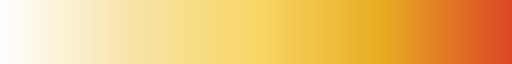

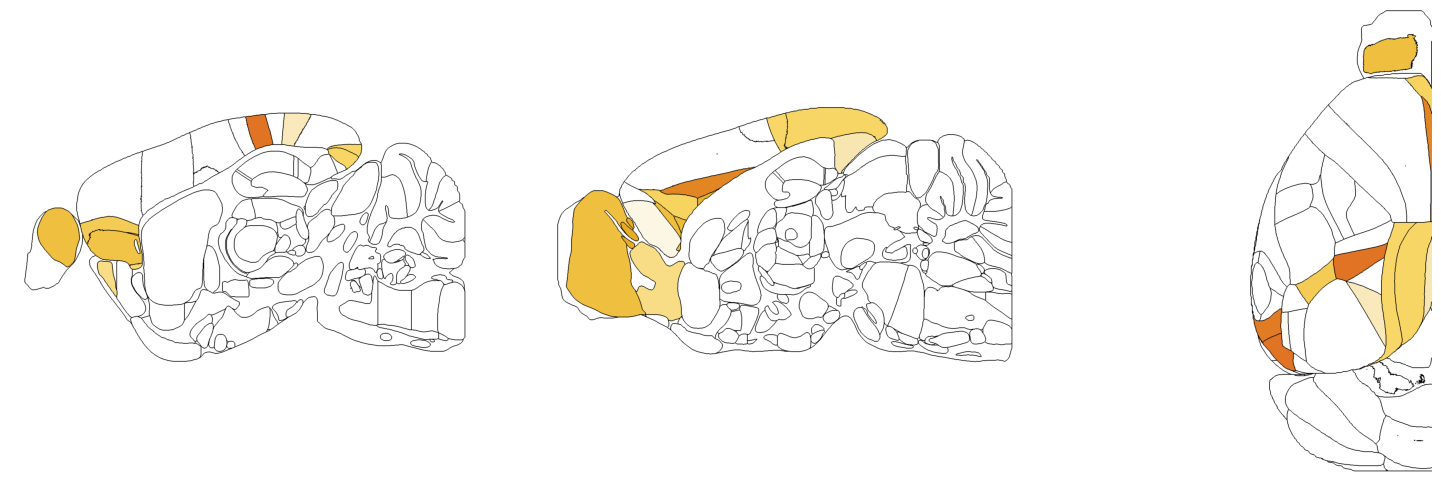

In [133]:
################ Custom Colormap #############

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["#ffffff","#F8E4AA","#F9D766","#E8AC22","#DA4727"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

#######################################


coord_1=(-4000+100*21)
coord_2=(-4000+100*31)
coord_3=(-4000+100*37)

###### inputs #################
# list_region_id: np array of region-id, integers 
# list_region_id: np array of values in associated regions, double float


#### generate sag slices 
im_sag_1=sag_slice_RGB(list_region_id, list_region_value,coord_1,cmap1)
im_sag_2=sag_slice_RGB(list_region_id, list_region_value,coord_2,cmap1)
im_sag_3=sag_slice_RGB(list_region_id, list_region_value,coord_3,cmap1)


#### generate cortex top view slice 
im_ctx_1=ctx_slice_RGB(list_region_id, list_region_value,cmap1)


# plot sag slices:

make_sag_plot(im_sag_1,im_sag_2,im_sag_3)



# plot top view slices:

make_ctx_plot(im_ctx_1)


# plot custom colorbar

cmap1

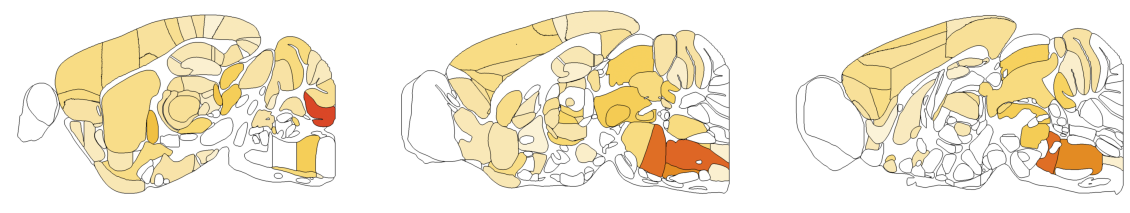

In [41]:
make_sag_plot(im_sag_1,im_sag_2,im_sag_3)

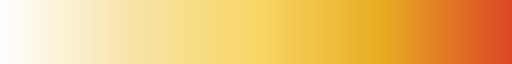

In [42]:
cmap1

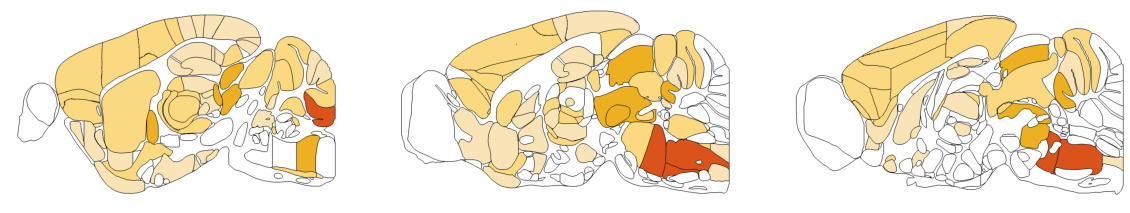

In [4]:
make_sag_plot(im_sag_1,im_sag_2,im_sag_3)

In [5]:
np.max(list_region_value)

0.3793103448275862

In [7]:
np.min(list_region_value)

0.0

In [16]:
np.ceil(0.0)

0.0

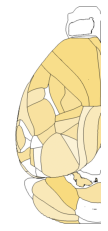

In [47]:
make_ctx_plot(im_ctx_1)

In [ ]:
###### ML coordinate ##########
coord_1=(-4000+100*21)
coord_2=(-4000+100*31)
coord_3=(-4000+100*37)

###### inputs #################
# list_region_id: np array of region-id, integers 
# list_region_id: np array of values in associated regions, double float


#### generate sag slices 
im_sag_1=sag_slice_RGB(list_region_id, list_region_value,coord_1,1)
im_sag_2=sag_slice_RGB(list_region_id, list_region_value,coord_2,1)
im_sag_3=sag_slice_RGB(list_region_id, list_region_value,coord_3,1)


#### generate cortex top view slice 
im_ctx_1=ctx_slice_RGB(list_region_id, list_region_value)





# plot sag slices:

make_sag_plot(im_sag_1,im_sag_2,im_sag_3)



# plot top view slices:

make_ctx_plot(im_ctx_1)